In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy.special import expit
import pymc3 as pm
import arviz as az
import theano.tensor as tt

In [47]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

Data accessible here: https://zenodo.org/record/845873#.WeDg9GhSw2x

In [48]:
df = pd.read_csv("data/cpc2018.csv")
df

,SubjID,Location,Gender,Age,Set,Condition,GameID,Ha,pHa,La,...,Trial,Button,B,Payoff,Forgone,RT,Apay,Bpay,Feedback,block
0,10100,Rehovot,M,28,1,ByProb,13,0,1.0,0,...,1,L,1,50,0,NaN,0,50,0,1
1,10100,Rehovot,M,28,1,ByProb,13,0,1.0,0,...,2,L,1,50,0,NaN,0,50,0,1
2,10100,Rehovot,M,28,1,ByProb,13,0,1.0,0,...,3,L,1,-50,0,NaN,0,-50,0,1
3,10100,Rehovot,M,28,1,ByProb,13,0,1.0,0,...,4,L,1,-50,0,NaN,0,-50,0,1
4,10100,Rehovot,M,28,1,ByProb,13,0,1.0,0,...,5,L,1,-50,0,NaN,0,-50,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510745,71109,Technion,M,24,7,ByProb,204,9,1.0,9,...,21,L,0,9,5,552.0,9,5,1,5
510746,71109,Technion,M,24,7,ByProb,204,9,1.0,9,...,22,L,0,9,5,355.0,9,5,1,5
510747,71109,Technion,M,24,7,ByProb,204,9,1.0,9,...,23,L,0,9,5,707.0,9,5,1,5
510748,71109,Technion,M,24,7,ByProb,204,9,1.0,9,...,24,L,0,9,5,493.0,9,5,1,5


* `SubjID`: Unique human subject identifier, made up of 5 digits. 1st digit marks the Set of games the subject faced (1-7), 2nd digit marks Location subject played in (0-1), last three digits have no meaning.

* `Location`: The physical location the subject was run in (“Technion”/“Rehovot”)
* `Gender`: Subject’s gender (M/F)
* `Age`: Subject’s age at time of experiment
* `Set`: ID for the set number that the subject faced (each set consists of the same 30 games). 1-5 are CPC15 data, 6-7 are CPC18’s Experiment 1 data.
* `Condition`: Legacy variable from CPC15 (“ByProb”/”ByFB”). Refers to the order condition by which subject saw the games within a set. CPC18 data will all be “ByProb” condition.
* `GameID`: Unique game (choice problem) identifier (1-210).
<< The next 12 variables define (jointly) the choice problem by defining the two possible distributions and any relationship between them. For more details on how each 12-tuple defines the exact distributions, see the paper >>
* `Ha`: Expected value of (High) lottery in Option A
* `pHa`: Probability to get payoff drawn from lottery in Option A
* `La`: Low payoff in Option A
* `LotShapeA`: Shape of lottery in Option A (“-“, “Symm”, “L-skew”, or “R-skew”) 
* `LotNumA`: Number of lottery outcomes in Option A
* `Hb`: Expected value of (High) lottery in Option B
* `pHb`: Probability to get payoff drawn from lottery in Option B
* `Lb`: Low payoff in Option B
* `LotShapeB`: Shape of lottery in Option B (“-“, “Symm”, “L-skew”, or “R-skew”)
* `LotNumB`: Number of lottery outcomes in Option B
* `Amb`: Whether Option B is ambiguous (i.e. its probabilities are not described to subjects;
Boolean)
* `Corr`: Whether payoffs generated by the two possible options are correlated and the sign of the correlation (-1/0/1)
* `Order`: The serial position of the current game within the sequence of 30 games the subject faced (1-30)
* `Trial`: The trial number within a game (1-25)
* `Button`: The on-screen side of the chosen button (“L”/”R”)
* `B`: The response variable. Whether or not the subject selected Option B in the current trial (Boolean)
* `Payoff`: The payoff the subject got from her/his choice in the current trial
* `Forgone`: The payoff the subject would have gotten had she/he selected the other option in the
current trial
* `RT`: Reaction time until choice of option (in milliseconds). Only measured for Sets 6, 7.
<< The next four variables can be computed directly from the previous variables. They are given for convenience. >>
* `APay`: The payoff provided by Option A in the current trial 
* `BPay`: The payoff provided by Option B in the current trial
* `Feedback`: Whether (full) feedback was provided for the subject regarding payoffs in the current trial
* `Block`: Number of time-block within the current game (each 5 trials define a block)

From Erev I, Ert E, Plonsky O, Cohen D, Cohen O. From anomalies to forecasts: Toward a descriptive model of decisions under risk, under ambiguity, and from experience. Psychol Rev. 2017 Jul;124(4):369-409. doi: 10.1037/rev0000062. Epub 2017 Mar 9. PMID: 28277716.

Accessible here: http://oriplonsky.com/wp-content/uploads/2017/09/Erev-et-al-2017.pdf

> The main properties of the problems in Table 1 include at least 11 dimensions.
Nine of the 11 dimensions can be described as parameters of the payoff distributions. These
parameters include: `LA`, `HA`, `pHA`, `LB`, `HB`, `pHB`, `LotNum`, `LotShape`, and `Corr`. In particular,
each problem in the space is a choice between Option A, which provides `HA` with probability
`pHA` or `LA` otherwise (with probability 1 − `pHA`), and Option B, which provides a lottery (that
has an expected value of `HB`) with probability `pHB`, and provides LB otherwise (with
probability 1 − `pHB`). The distribution of the lottery around its expected value (`HB`) is
determined by the parameters `LotNum` (which defines the number of possible outcomes in the 
lottery) and `LotShape` (which defines whether the distribution is symmetric around its mean,
right-skewed, left-skewed, or undefined if `LotNum` = 1), as explained in Appendix A. The
Corr parameter determines whether there is a correlation (positive, negative, or zero) between
the payoffs of the two options.
The tenth parameter, Ambiguity (`Amb`), captures the precision of the initial
information the decision maker receives concerning the probabilities of the possible
outcomes in Option B. We focus on the two extreme cases: `Amb` = 1 implies no initial
information concerning these probabilities (they are described with undisclosed fixed
parameters), and `Amb` = 0 implies complete information and no ambiguity (as in Allais, 1953;
Kahneman & Tversky, 1979).
The eleventh dimension in the space is the amount of feedback the decision maker
receives after making a decision. As Table 1 shows, some phenomena emerge in decisions
without feedback (i.e., decisions from description), and other phenomena emerge when the
decision maker can rely on feedback (i.e., decisions from experience). We studied this
dimension within problem. That is, decision makers faced each problem first without
feedback, and then with full feedback (i.e., realization of the obtained and forgone outcomes
following each choice).

In [49]:
len(df.SubjID.unique())

686

In [50]:
(df.Amb == 0).sum()

443000

In [51]:
sorted(df.pHb.unique())

[0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 0.99, 1.0]

In [52]:
sorted(df.pHa.unique())

[0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 0.99, 1.0]

In [53]:
print(sorted(df.Ha.unique()))

[-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53, 58, 60, 65, 67, 68, 71, 72, 74, 76, 83, 85, 87, 92, 94, 104]


In [54]:
print(sorted(df.La.unique()))

[-47, -41, -40, -39, -38, -37, -36, -33, -29, -27, -26, -24, -22, -20, -18, -17, -16, -14, -13, -11, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [55]:
print(sorted(df.Hb.unique()))

[-11, -10, -5, -4, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 59, 60, 61, 64, 65, 68, 70, 71, 73, 75, 76, 77, 79, 80, 82, 84, 88, 90, 91, 92, 93, 97, 100, 101, 102, 103, 112, 116]


In [56]:
print(sorted(df.Lb.unique()))

[-50, -49, -46, -45, -44, -43, -40, -37, -36, -35, -34, -33, -32, -31, -30, -29, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 36]


In [57]:
data = df[(df.LotNumB == 1) & (df.LotNumA == 1) & (df.Amb == 0) 
          & (df.Ha >= 0) & (df.Hb >= 0) & (df.La >= 0) & (df.Lb >= 0)]  # & (df.La ==0)  & (df.Lb == 0)
data

,SubjID,Location,Gender,Age,Set,Condition,GameID,Ha,pHa,La,...,Trial,Button,B,Payoff,Forgone,RT,Apay,Bpay,Feedback,block
25,10100,Rehovot,M,28,1,ByProb,25,2,1.0,2,...,1,R,0,2,1,NaN,2,1,0,1
26,10100,Rehovot,M,28,1,ByProb,25,2,1.0,2,...,2,R,0,2,3,NaN,2,3,0,1
27,10100,Rehovot,M,28,1,ByProb,25,2,1.0,2,...,3,R,0,2,3,NaN,2,3,0,1
28,10100,Rehovot,M,28,1,ByProb,25,2,1.0,2,...,4,R,0,2,1,NaN,2,1,0,1
29,10100,Rehovot,M,28,1,ByProb,25,2,1.0,2,...,5,R,0,2,3,NaN,2,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510395,71109,Technion,M,24,7,ByProb,186,19,1.0,19,...,21,L,0,19,5,405.0,19,5,1,5
510396,71109,Technion,M,24,7,ByProb,186,19,1.0,19,...,22,L,0,19,5,470.0,19,5,1,5
510397,71109,Technion,M,24,7,ByProb,186,19,1.0,19,...,23,L,0,19,5,367.0,19,5,1,5
510398,71109,Technion,M,24,7,ByProb,186,19,1.0,19,...,24,L,0,19,5,499.0,19,5,1,5


In [58]:
print(sorted(data.pHa.unique()))
print(sorted(data.pHb.unique()))

print(sorted(data.Ha.unique()))

print(sorted(data.La.unique()))

print(sorted(data.Hb.unique()))

print(sorted(data.Lb.unique()))

[0.01, 0.1, 0.25, 0.5, 0.6, 0.95, 1.0]
[0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 1.0]
[1, 2, 3, 6, 7, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 28, 30, 32, 39, 51, 53, 60, 85]
[0, 1, 2, 3, 4, 7, 9, 10, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 30]
[2, 3, 4, 6, 8, 9, 12, 16, 20, 21, 32, 33, 34, 35, 38, 41, 42, 43, 44, 45, 48, 50, 54, 59, 64, 65, 70, 90, 97, 100, 101]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 16, 17, 19, 23, 24, 28, 36]


In [59]:
data = data.drop(['Location', 'Condition', 'GameID', 'Set', 'Gender', 'Age', 'Amb', 'RT', 
                                'Button', 'LotShapeA', 'LotShapeB','Corr', 'block'], axis=1)
data

,SubjID,Ha,pHa,La,LotNumA,Hb,pHb,Lb,LotNumB,Order,Trial,B,Payoff,Forgone,Apay,Bpay,Feedback
25,10100,2,1.0,2,1,3,0.5,1,1,2,1,0,2,1,2,1,0
26,10100,2,1.0,2,1,3,0.5,1,1,2,2,0,2,3,2,3,0
27,10100,2,1.0,2,1,3,0.5,1,1,2,3,0,2,3,2,3,0
28,10100,2,1.0,2,1,3,0.5,1,1,2,4,0,2,1,2,1,0
29,10100,2,1.0,2,1,3,0.5,1,1,2,5,0,2,3,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510395,71109,19,1.0,19,1,97,0.1,5,1,16,21,0,19,5,19,5,1
510396,71109,19,1.0,19,1,97,0.1,5,1,16,22,0,19,5,19,5,1
510397,71109,19,1.0,19,1,97,0.1,5,1,16,23,0,19,5,19,5,1
510398,71109,19,1.0,19,1,97,0.1,5,1,16,24,0,19,5,19,5,1


In [60]:
data = pd.DataFrame({
    "pA": data.pHa.values,
    "xA0": data.Ha.values,
    "xA1": data.La.values,
    "pB": data.pHb.values,
    "xB0": data.Hb.values,
    "xB1": data.Lb.values,
    "y": data.B.values
})

In [61]:
data

,pA,xA0,xA1,pB,xB0,xB1,y
0,1.0,2,2,0.5,3,1,0
1,1.0,2,2,0.5,3,1,0
2,1.0,2,2,0.5,3,1,0
3,1.0,2,2,0.5,3,1,0
4,1.0,2,2,0.5,3,1,0
...,...,...,...,...,...,...,...
103120,1.0,19,19,0.1,97,5,0
103121,1.0,19,19,0.1,97,5,0
103122,1.0,19,19,0.1,97,5,0
103123,1.0,19,19,0.1,97,5,0


In [62]:
print(sorted(data.pA.unique()))
print(sorted(data.pB.unique()))

print(sorted(data.xA0.unique()))

print(sorted(data.xA1.unique()))

print(sorted(data.xB0.unique()))

print(sorted(data.xB1.unique()))

[0.01, 0.1, 0.25, 0.5, 0.6, 0.95, 1.0]
[0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 1.0]
[1, 2, 3, 6, 7, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 28, 30, 32, 39, 51, 53, 60, 85]
[0, 1, 2, 3, 4, 7, 9, 10, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 30]
[2, 3, 4, 6, 8, 9, 12, 16, 20, 21, 32, 33, 34, 35, 38, 41, 42, 43, 44, 45, 48, 50, 54, 59, 64, 65, 70, 90, 97, 100, 101]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 16, 17, 19, 23, 24, 28, 36]


In [73]:
def u_pow(x, theta): return x**theta[0]

In [74]:
def u_exp(x, theta): return 1 - np.exp(-theta[0]*x)

In [92]:
def u_lin(x, theta=None): return x

In [75]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+

    tau = param[0]
    theta = param[1:]
    
    pA = data.pA.values
    pB = data.pB.values
    
    xA0 = data.xA0.values
    xA1 = data.xA1.values
    
    xB0 = data.xB0.values
    xB1 = data.xB1.values
    
    y = data.y.values 
    
    seuA = pA * u_m(xA0, theta) + (1-pA) * u_m(xA1, theta)
    seuB = pB * u_m(xB0, theta) + (1-pB) * u_m(xB1, theta)

    diff_eu = seuB - seuA

    p_choice_B = scipy.special.expit(tau*diff_eu)
    p_choice_y = p_choice_B**y * (1-p_choice_B)**(1-y)
    
    lls = np.log(p_choice_y + np.finfo(float).eps).sum()
    return - lls

In [76]:
def optimize(data, u_m=u_pow, x0=None, seed=12345):
    np.random.seed(seed)
    if x0 is None:
        x0 = (1.0, 1.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))#, bounds=((0.0, None), (0.0, None)))
    return softplus(opt.x)

In [77]:
optimize(data, u_m=u_pow)

array([0.61429589, 0.81746922])

# Model discrepancy

In [78]:
np.random.seed(1234)
data_gp = data.sample(200)
u_model = u_pow

opt_param = optimize(data_gp, u_m=u_model)
tau_model = opt_param[0]
theta_model = opt_param[1:]
print(f"tau={tau_model}, theta={theta_model}")

tau=0.5873439148017501, theta=[0.88222107]


In [39]:
pA = data_gp.pA.values
pB = data_gp.pB.values

xA0 = data_gp.xA0.values
xA1 = data_gp.xA1.values

xB0 = data_gp.xB0.values
xB1 = data_gp.xB1.values

y = data_gp.y.values 

n = len(y)

x = np.hstack((xA0, xA1, xB0, xB1))
p = np.hstack((pA, 1-pA, pB, 1-pB))
x_order = np.argsort(x)
x_sorted = x[x_order]
p_sorted = p[x_order]
undo_sorted = np.argsort(x_order)

X = x_sorted.reshape(-1, 1)
uX = u_model(X, theta_model)

In [40]:
with pm.Model() as model:

    ρ = pm.InverseGamma('ρ', 2, 2)  # (1, 8)
    η = pm.HalfCauchy('η', 5)

    M = pm.gp.mean.Constant(uX.flatten())
    
    # # Using ratio
    # K = tt.dot(uX, uX.T) *  η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    # Using difference
    # K = η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    K = tt.dot(uX, uX.T) *  η**2 * pm.gp.cov.ExpQuad(1, ρ) 

    gp = pm.gp.Latent(mean_func=M, cov_func=K)
    f = gp.prior("f", X=X)

    est_eu =  p_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]

    est_eu_A = est_eu_unsorted[:n] + est_eu_unsorted[n:2*n]
    est_eu_B = est_eu_unsorted[2*n:3*n] + est_eu_unsorted[3*n:]

    est_diff_eu = est_eu_B - est_eu_A

    est_p_choice_B = pm.math.invlogit(tau_model*est_diff_eu)
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice_B, observed=y)

In [41]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7728 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [42]:
with model:
    samples = pm.sample_posterior_predictive(trace, var_names=["f"])

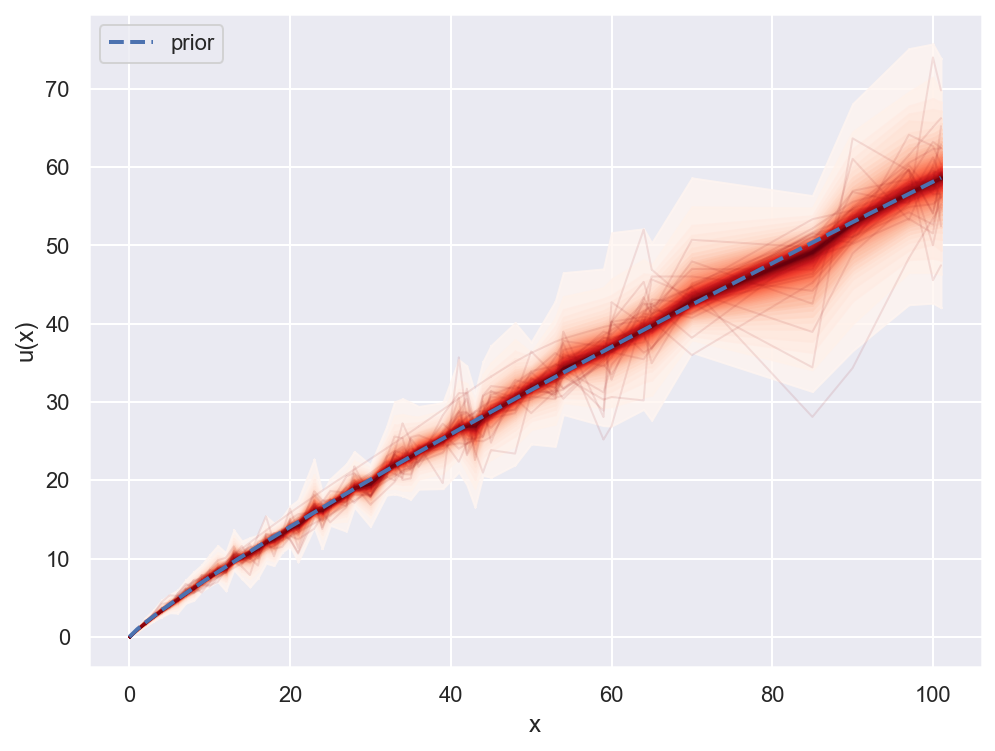

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, samples["f"], x_sorted.reshape(-1, 1))
ax.plot(x_sorted, u_model(x_sorted, theta_model), lw=2, ls='--', color='C0', label="prior")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend();

In [44]:
r = (samples["f"]+1e-06) / (u_model(x_sorted, theta_model) + 1e-06)

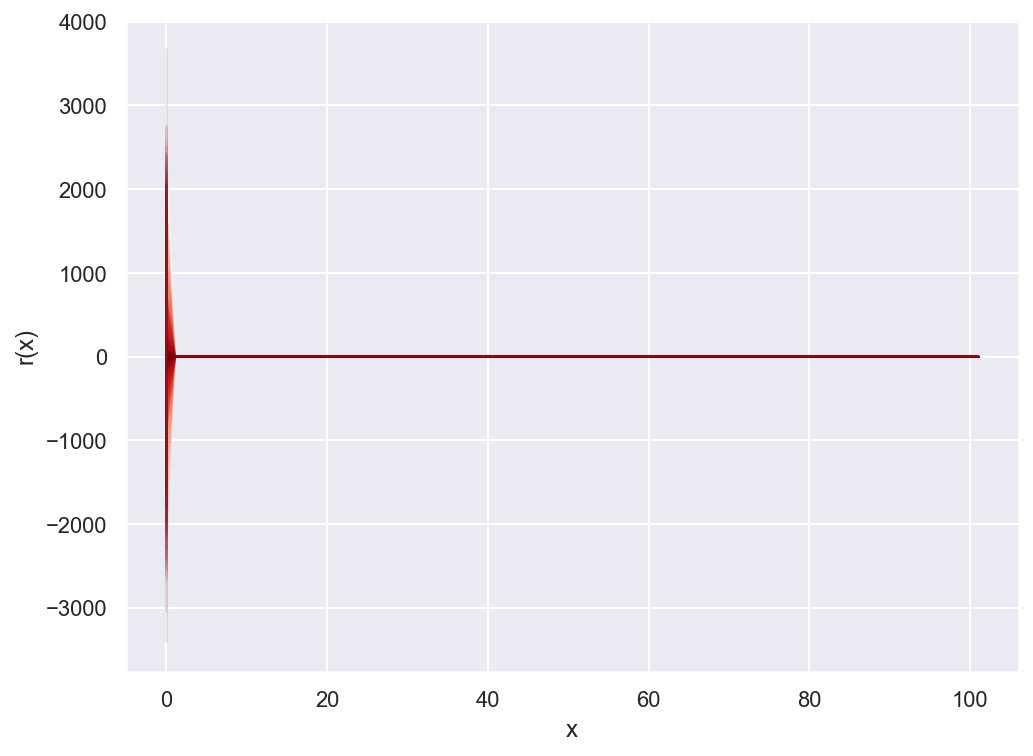

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, r, x_sorted)
ax.set_xlabel("x")
ax.set_ylabel("r(x)");

# Assuming linear utility

In [ ]:
np.random.seed(1234)
data_gp = data.sample(200)

u_model = u_lin
theta_model = None

In [85]:
pA = data_gp.pA.values
pB = data_gp.pB.values

xA0 = data_gp.xA0.values
xA1 = data_gp.xA1.values

xB0 = data_gp.xB0.values
xB1 = data_gp.xB1.values

y = data_gp.y.values 

n = len(y)

x = np.hstack((xA0, xA1, xB0, xB1))
p = np.hstack((pA, 1-pA, pB, 1-pB))
x_order = np.argsort(x)
x_sorted = x[x_order]
p_sorted = p[x_order]
undo_sorted = np.argsort(x_order)

X = x_sorted.reshape(-1, 1)
uX = u_model(X, theta_model)

In [86]:
with pm.Model() as model:

    ρ = pm.InverseGamma('ρ', 2, 2)
    η = pm.HalfCauchy('η', 5)

    M = pm.gp.mean.Constant(uX.flatten())
    
    # # Using ratio
    # K = tt.dot(uX, uX.T) *  η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    # Using difference
    # K = η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    K = tt.dot(uX, uX.T) *  η**2 * pm.gp.cov.ExpQuad(1, ρ) 

    gp = pm.gp.Latent(mean_func=M, cov_func=K)
    f = gp.prior("f", X=X)

    est_eu =  p_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]

    est_eu_A = est_eu_unsorted[:n] + est_eu_unsorted[n:2*n]
    est_eu_B = est_eu_unsorted[2*n:3*n] + est_eu_unsorted[3*n:]

    est_diff_eu = est_eu_B - est_eu_A

    est_p_choice_B = pm.math.invlogit(tau_model*est_diff_eu)
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice_B, observed=y)

In [87]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10141 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8125293108037063, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [88]:
with model:
    samples = pm.sample_posterior_predictive(trace, var_names=["f"])

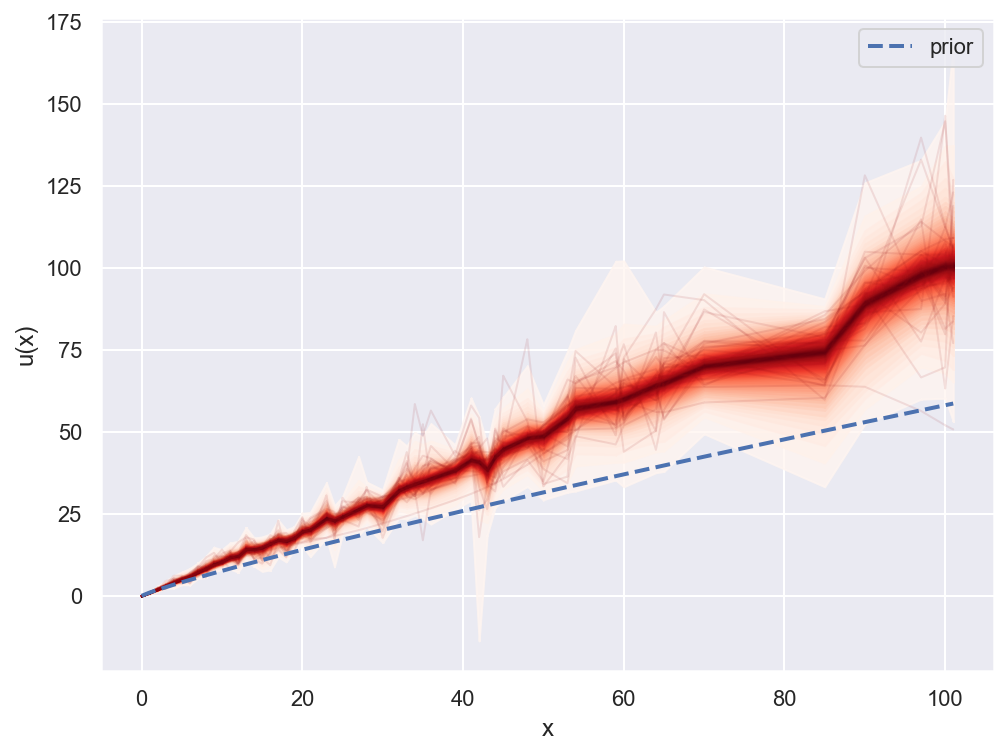

In [89]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, samples["f"], x_sorted.reshape(-1, 1))
ax.plot(x_sorted, u_model(x_sorted, theta_model), lw=2, ls='--', color='C0', label="prior")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend();

In [90]:
r = (samples["f"]+1e-06) / (u_model(x_sorted, theta_model) + 1e-06)

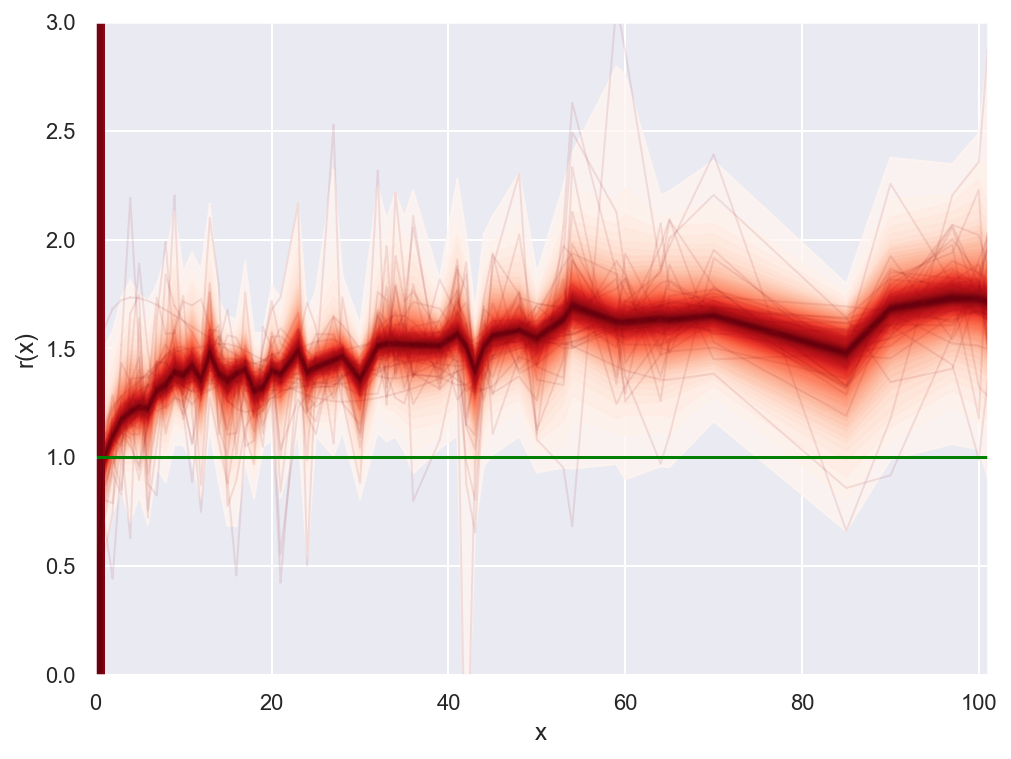

In [98]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, r, x_sorted)
ax.set_xlabel("x")
ax.set_ylabel("r(x)");
ax.set_xlim(0, max(x_sorted))
ax.set_ylim(0, 3)
ax.axhline(y=1, color="green");

# Assuming 'Exp' utility

In [99]:
np.random.seed(1234)
data_gp = data.sample(200)
u_model = u_exp  # !!!

opt_param = optimize(data_gp, u_m=u_model)
tau_model = opt_param[0]
theta_model = opt_param[1:]
print(f"tau={tau_model}, theta={theta_model}")

tau=79.08963960623159, theta=[0.00514734]


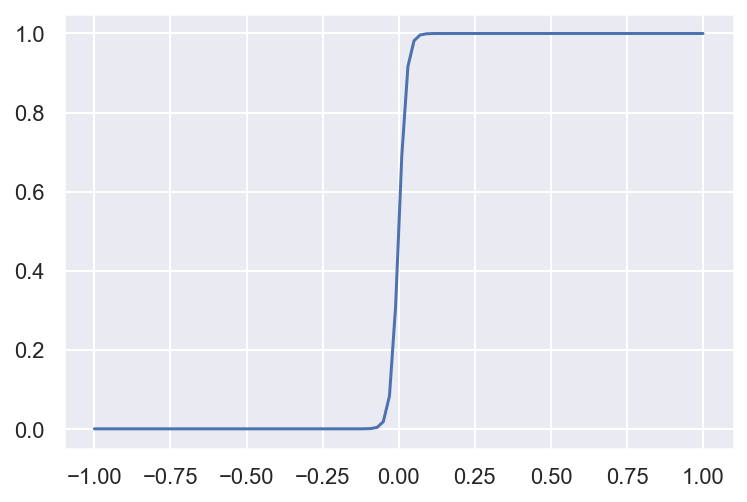

In [105]:
x = np.linspace(-1, 1, 100)
y = expit(tau_model*x)
plt.plot(x, y)

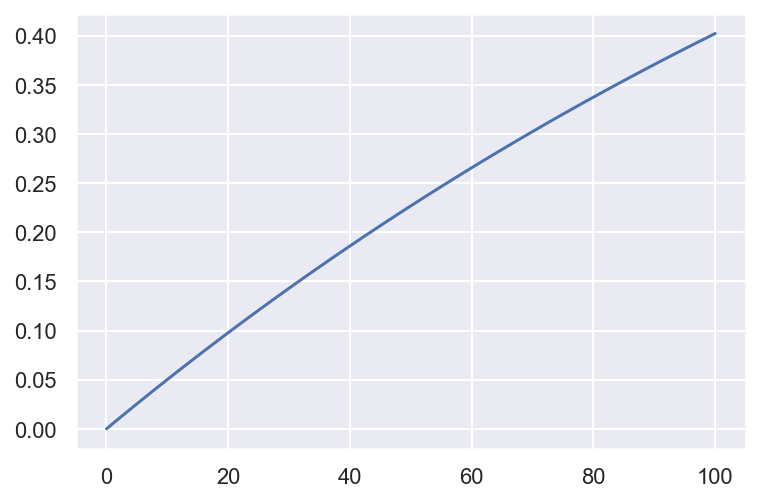

In [113]:
x = np.linspace(0, 100, 100)
y = u_exp(x, theta_model)
plt.plot(x, y)

In [114]:
pA = data_gp.pA.values
pB = data_gp.pB.values

xA0 = data_gp.xA0.values
xA1 = data_gp.xA1.values

xB0 = data_gp.xB0.values
xB1 = data_gp.xB1.values

y = data_gp.y.values 

n = len(y)

x = np.hstack((xA0, xA1, xB0, xB1))
p = np.hstack((pA, 1-pA, pB, 1-pB))
x_order = np.argsort(x)
x_sorted = x[x_order]
p_sorted = p[x_order]
undo_sorted = np.argsort(x_order)

X = x_sorted.reshape(-1, 1)
uX = u_model(X, theta_model)

In [115]:
with pm.Model() as model:

    ρ = pm.InverseGamma('ρ', 2, 2)
    η = pm.HalfCauchy('η', 5)

    M = pm.gp.mean.Constant(uX.flatten())
    
    # # Using ratio
    # K = tt.dot(uX, uX.T) *  η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    # Using difference
    # K = η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    K = tt.dot(uX, uX.T) *  η**2 * pm.gp.cov.ExpQuad(1, ρ) 

    gp = pm.gp.Latent(mean_func=M, cov_func=K)
    f = gp.prior("f", X=X)

    est_eu =  p_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]

    est_eu_A = est_eu_unsorted[:n] + est_eu_unsorted[n:2*n]
    est_eu_B = est_eu_unsorted[2*n:3*n] + est_eu_unsorted[3*n:]

    est_diff_eu = est_eu_B - est_eu_A

    est_p_choice_B = pm.math.invlogit(tau_model*est_diff_eu)
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice_B, observed=y)

In [116]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9686 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8367577282413031, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [117]:
with model:
    samples = pm.sample_posterior_predictive(trace, var_names=["f"])

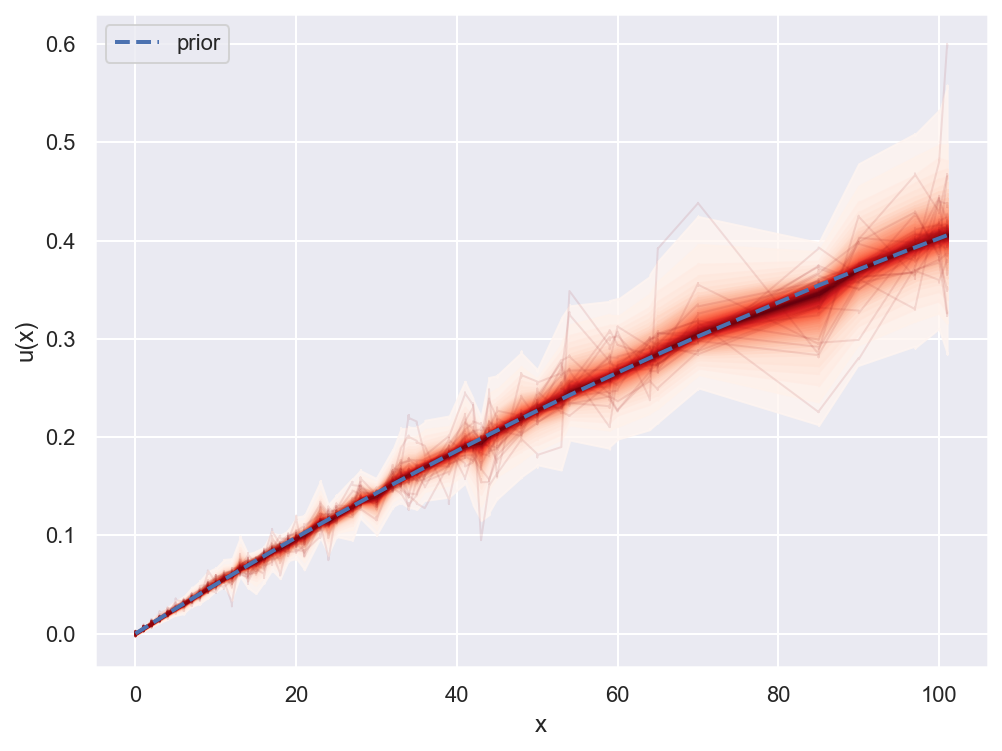

In [118]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, samples["f"], x_sorted.reshape(-1, 1))
ax.plot(x_sorted, u_model(x_sorted, theta_model), lw=2, ls='--', color='C0', label="prior")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend();

In [119]:
r = (samples["f"]+1e-06) / (u_model(x_sorted, theta_model) + 1e-06)

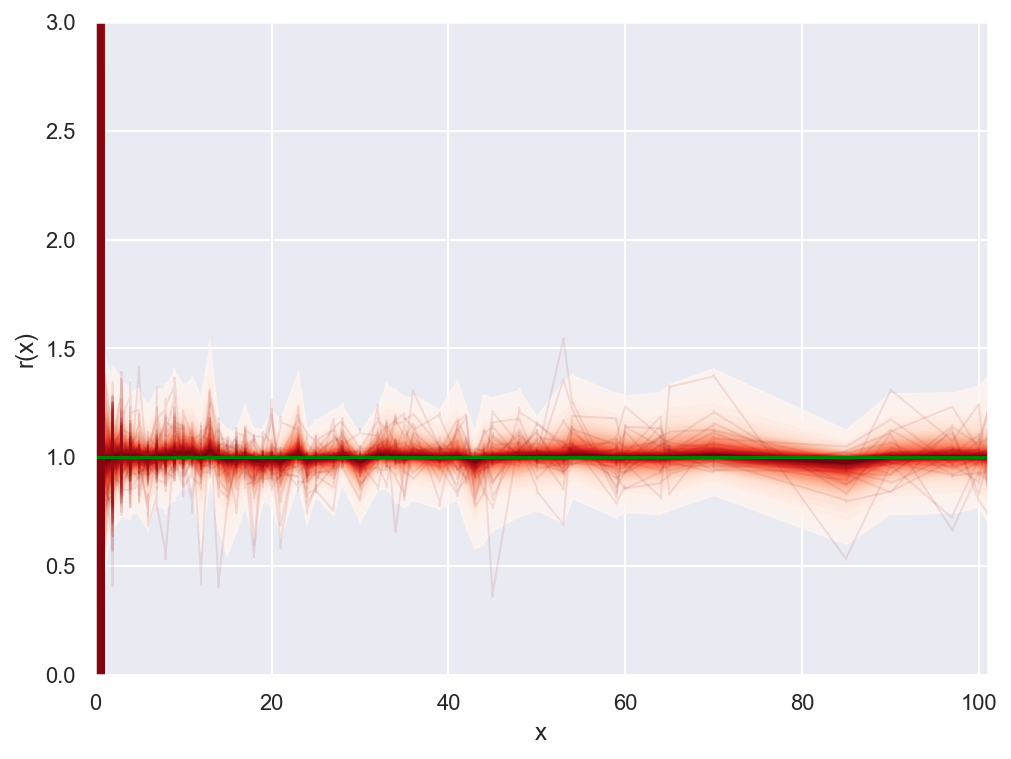

In [120]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, r, x_sorted)
ax.set_xlabel("x")
ax.set_ylabel("r(x)");
ax.set_xlim(0, max(x_sorted))
ax.set_ylim(0, 3)
ax.axhline(y=1, color="green");

# Evaluating the probability distortion

In [121]:
np.random.seed(1234)
data_gp = data.sample(200)
u_model = u_pow  # !!!

opt_param = optimize(data_gp, u_m=u_model)
tau_model = opt_param[0]
theta_model = opt_param[1:]
print(f"tau={tau_model}, theta={theta_model}")

tau=0.5873439148017501, theta=[0.88222107]


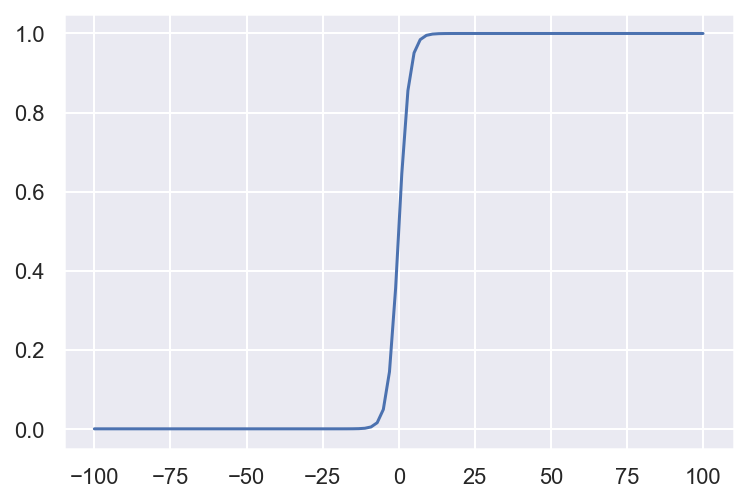

In [123]:
x = np.linspace(-100, 100, 100)
y = expit(tau_model*x)
plt.plot(x, y)

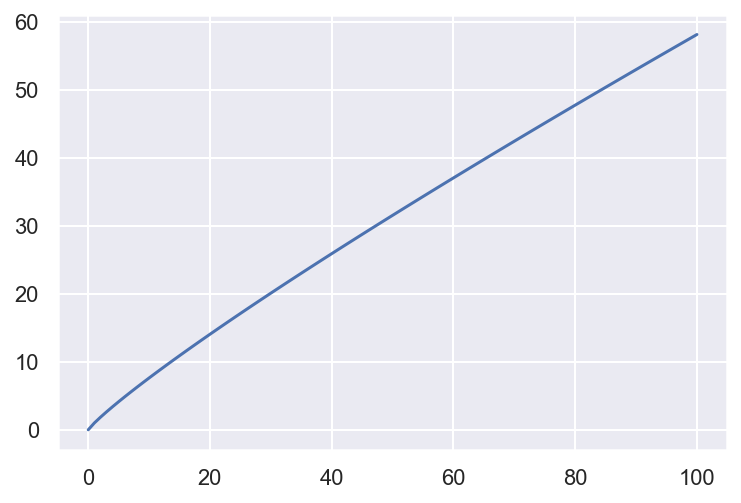

In [124]:
x = np.linspace(0, 100, 100)
y = u_model(x, theta_model)
plt.plot(x, y)

In [125]:
pA = data_gp.pA.values
pB = data_gp.pB.values

xA0 = data_gp.xA0.values
xA1 = data_gp.xA1.values

xB0 = data_gp.xB0.values
xB1 = data_gp.xB1.values

y = data_gp.y.values 

n = len(y)

x = np.hstack((xA0, xA1, xB0, xB1))
p = np.hstack((pA, pB))
p_order = np.argsort(p)
p_sorted = p[p_order]
undo_sorted = np.argsort(p_order)

X = p_sorted.reshape(-1, 1)
mX = X.copy()

uxA0 = u_model(xA0, theta_model)
uxA1 = u_model(xA1, theta_model)
uxB0 = u_model(xB0, theta_model)
uxB1 = u_model(xB1, theta_model)

In [127]:
with pm.Model() as model:

    ρ = pm.InverseGamma('ρ', 2, 2)
    η = pm.HalfCauchy('η', 5)

    M = pm.gp.mean.Constant(mX.flatten())
    
    # # Using ratio
    # K = tt.dot(uX, uX.T) *  η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    # Using difference
    # K = η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    K = tt.dot(mX, mX.T) *  η**2 * pm.gp.cov.ExpQuad(1, ρ) 

    gp = pm.gp.Latent(mean_func=M, cov_func=K)
    f = gp.prior("f", X=X)
    
    est_p_unsorted = f[undo_sorted]
    
    est_pA =  est_p_unsorted[:n]
    est_pB = est_p_unsorted[n:]

    est_eu_A = est_pA*uxA0 + (1-est_pA)*uxA1
    est_eu_B = est_pB*uxB0 + (1-est_pB)*uxB1 

    est_diff_eu = est_eu_B - est_eu_A

    est_p_choice_B = pm.math.invlogit(tau_model*est_diff_eu)
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice_B, observed=y)

In [128]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1349 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [129]:
with model:
    samples = pm.sample_posterior_predictive(trace, var_names=["f"])

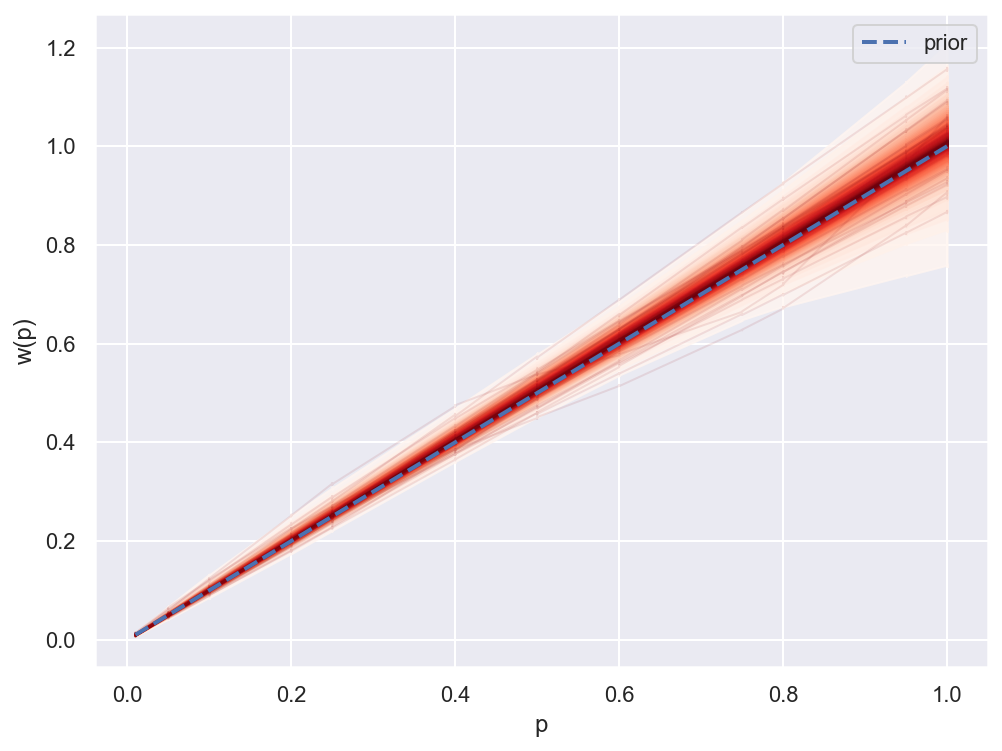

In [133]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, samples["f"], p_sorted)
ax.plot(p_sorted, p_sorted, lw=2, ls='--', color='C0', label="prior")
ax.set_xlabel("p")
ax.set_ylabel("w(p)")
ax.legend();

In [131]:
r = (samples["f"]+1e-06) / (p_sorted + 1e-06)

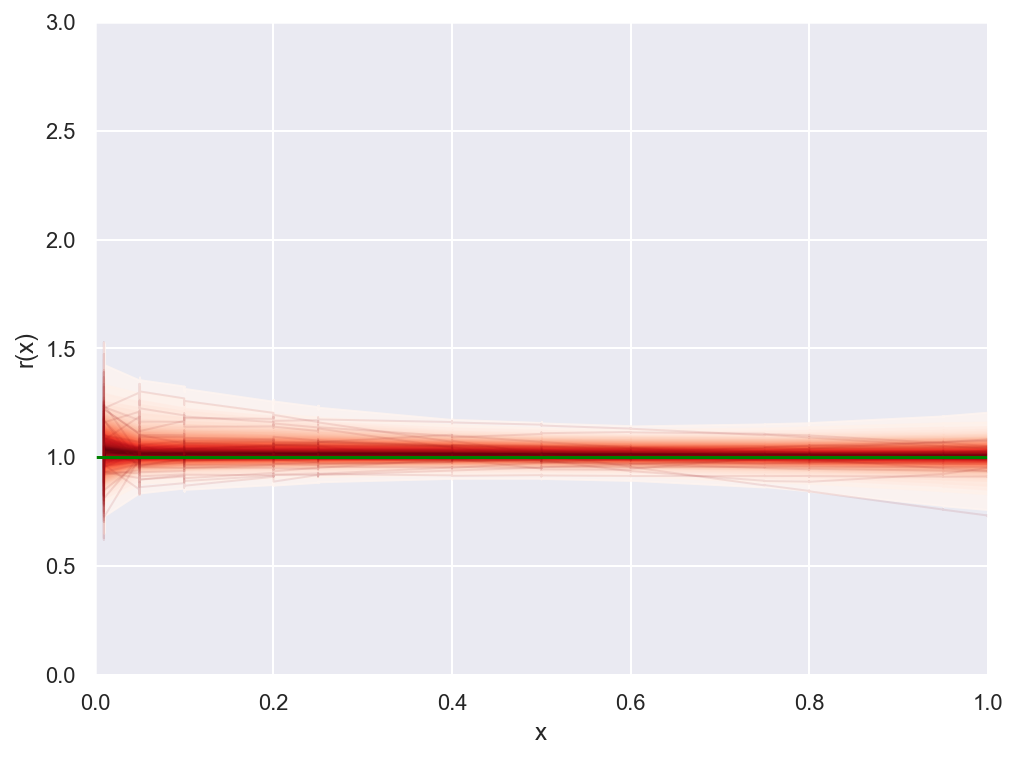

In [132]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, r, p_sorted)
ax.set_xlabel("x")
ax.set_ylabel("r(x)");
ax.set_xlim(0, 1)
ax.set_ylim(0, 3)
ax.axhline(y=1, color="green");

# Assuming non-linear probability

In [168]:
def u_pow(x, theta): return x**theta

def u_exp(x, theta): return 1 - np.exp(-theta*x)

def u_lin(x, theta): return x

def prelec(p, theta): return np.exp(-(-np.log(p))**theta) 

In [169]:
def softplus(x):
    return np.log(np.exp(x) + 1)

def objective(data, u, w):
    
    pA = data.pA.values
    pB = data.pB.values

    xA0 = data.xA0.values
    xA1 = data.xA1.values

    xB0 = data.xB0.values
    xB1 = data.xB1.values

    y = data.y.values 
    
    def run(param):
        
        tau = softplus(param[0])
        theta_u = softplus(param[1])
        theta_w = expit(param[2])

        wpA = w(pA, theta_w)
        wpB = w(pB, theta_w)
        
        uxA0 = u(xA0, theta_u)
        uxA1 = u(xA1, theta_u)
        uxB0 = u(xB0, theta_u)
        uxB1 = u(xB1, theta_u)

        seuA = wpA * uxA0 + (1-wpA) * uxA1
        seuB = wpB * uxB0 + (1-wpB) * uxB1

        diff_seu = seuB - seuA

        p_choice_B = scipy.special.expit(tau*diff_seu)
        p_choice_y = p_choice_B**y * (1-p_choice_B)**(1-y)

        lls = np.log(p_choice_y + np.finfo(float).eps).sum()
        return - lls
    return run

def optimize(data, u=u_pow, w=prelec, seed=12345):
    np.random.seed(seed)
    opt = scipy.optimize.minimize(objective(data, u, w), x0=(1.0, 1.0, 1.0))
    tau = softplus(opt.x[0])
    theta_u = softplus(opt.x[1])
    theta_w = expit(opt.x[2])
    return tau, theta_u, theta_w

In [170]:
optimize(data)

(0.7032773703000763, 0.7950043081776034, 0.857790055883722)

In [176]:
np.random.seed(1234)
data_gp = data.sample(200)
u_model = u_pow  # !!!
w_model = prelec

tau, theta_u, theta_w = optimize(data_gp, u=u_model, w=w_model)
print(f"tau={tau_model}, theta_u={theta_u}, theta_w={theta_w}")

tau=0.5873439148017501, theta_u=0.8670798218767025, theta_w=0.93767613141367


<ipython-input-168-b592728b9645>:7: RuntimeWarning: divide by zero encountered in log
  def prelec(p, theta): return np.exp(-(-np.log(p))**theta)


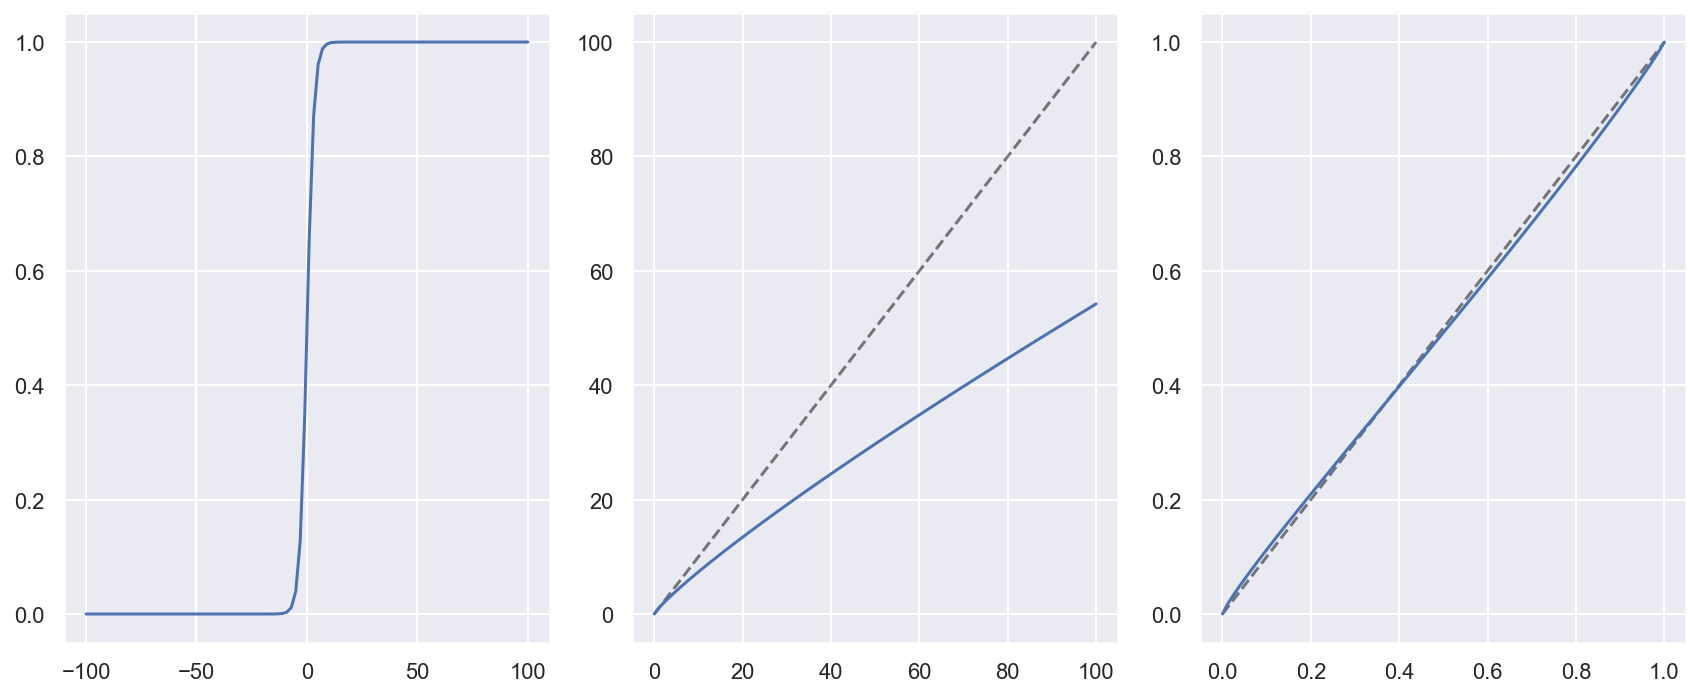

In [177]:
fig, axes = plt.subplots(ncols=3, figsize=(12,5))

ax = axes[0]
x = np.linspace(-100, 100, 100)
y = expit(tau*x)
ax.plot(x, y)

ax = axes[1] 
x = np.linspace(0, 100, 100)
y = u_model(x, theta_u)
ax.plot(x, x, color="black", alpha=0.5, ls="--")
ax.plot(x, y)

ax = axes[2] 
x = np.linspace(0, 1, 100)
y = w_model(x, theta_w)
ax.plot(x, x, color="black", alpha=0.5, ls="--")
ax.plot(x, y)

fig.tight_layout()

In [178]:
pA = data_gp.pA.values
pB = data_gp.pB.values

xA0 = data_gp.xA0.values
xA1 = data_gp.xA1.values

xB0 = data_gp.xB0.values
xB1 = data_gp.xB1.values

y = data_gp.y.values 

n = len(y)

x = np.hstack((xA0, xA1, xB0, xB1))
p = np.hstack((pA, pB))
p_order = np.argsort(p)
p_sorted = p[p_order]
undo_sorted = np.argsort(p_order)

X = p_sorted.reshape(-1, 1)
mX = w_model(p_sorted, theta_w)

uxA0 = u_model(xA0, theta_u)
uxA1 = u_model(xA1, theta_u)
uxB0 = u_model(xB0, theta_u)
uxB1 = u_model(xB1, theta_u)

In [179]:
with pm.Model() as model:

    ρ = pm.InverseGamma('ρ', 2, 2)
    η = pm.HalfCauchy('η', 5)

    M = pm.gp.mean.Constant(mX.flatten())
    
    # # Using ratio
    # K = tt.dot(uX, uX.T) *  η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    # Using difference
    # K = η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    K = tt.dot(mX, mX.T) *  η**2 * pm.gp.cov.ExpQuad(1, ρ) 

    gp = pm.gp.Latent(mean_func=M, cov_func=K)
    f = gp.prior("f", X=X)
    
    est_p_unsorted = f[undo_sorted]
    
    est_pA =  est_p_unsorted[:n]
    est_pB = est_p_unsorted[n:]

    est_eu_A = est_pA*uxA0 + (1-est_pA)*uxA1
    est_eu_B = est_pB*uxB0 + (1-est_pB)*uxB1 

    est_diff_eu = est_eu_B - est_eu_A

    est_p_choice_B = pm.math.invlogit(tau_model*est_diff_eu)
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice_B, observed=y)

In [180]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1704 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [181]:
with model:
    samples = pm.sample_posterior_predictive(trace, var_names=["f"])

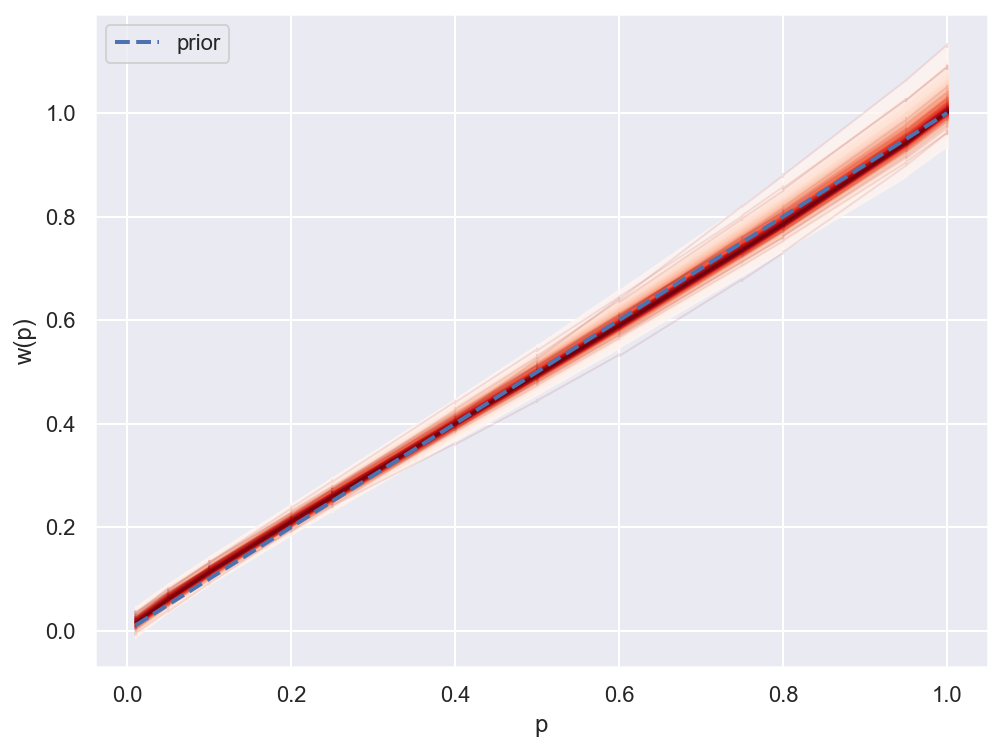

In [182]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, samples["f"], p_sorted)
ax.plot(p_sorted, p_sorted, lw=2, ls='--', color='C0', label="prior")
ax.set_xlabel("p")
ax.set_ylabel("w(p)")
ax.legend();

In [183]:
r = (samples["f"]+1e-06) / (w_model(p_sorted, theta_w) + 1e-06)

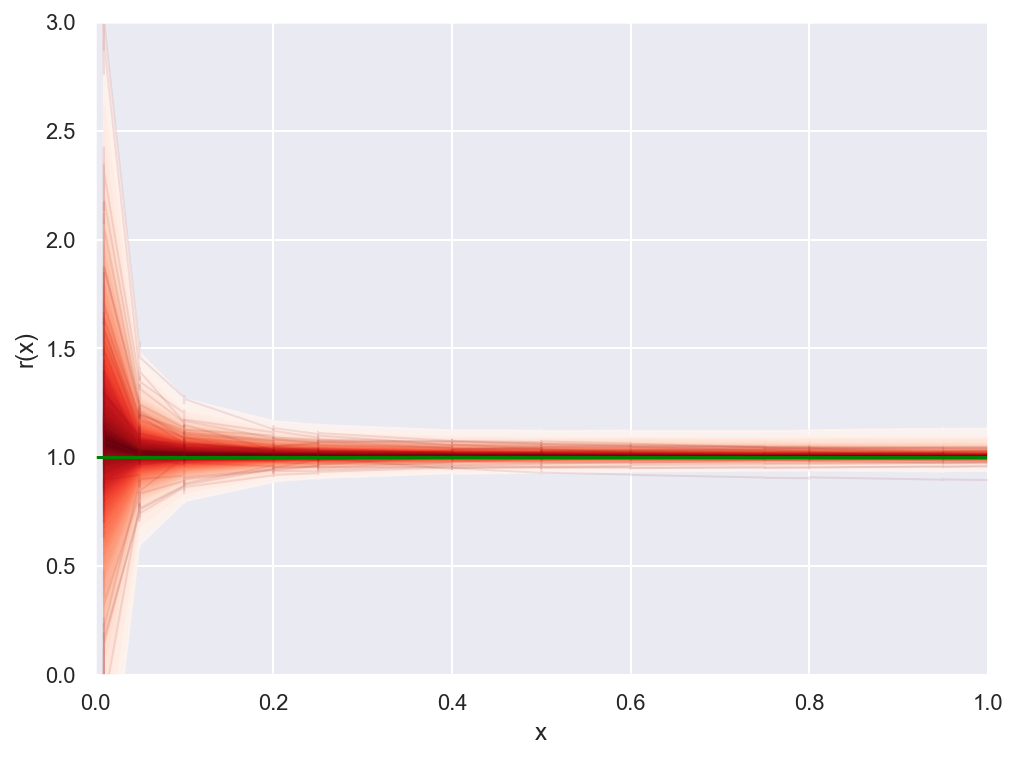

In [184]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, r, p_sorted)
ax.set_xlabel("x")
ax.set_ylabel("r(x)");
ax.set_xlim(0, 1)
ax.set_ylim(0, 3)
ax.axhline(y=1, color="green");

# Assumming strong probability distortion?